In [72]:
import os
import random
import datetime

import numpy as np
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from matplotlib import pyplot as plt
%matplotlib inline

In [68]:
IMAGE_BASE_PATH = '/Users/huanghao/workspace/learning/llm/vids/video_screenshots'
LABEL_TOOL_PATH = '/Users/huanghao/workspace/learning/llm/vids/label-tool/'
POSITIVE_LABEL_FILE = os.path.join(LABEL_TOOL_PATH, 'positive_labels.txt')
NEGATIVE_LABEL_FILE = os.path.join(LABEL_TOOL_PATH, 'negative_labels.txt')

BATCH_SIZE = 16
IMG_SIZE = 224

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # 调整到相同尺寸
    transforms.ToTensor(),                    # 转换为 PyTorch 张量
    transforms.Normalize([0.5], [0.5])        # 归一化
])

class CustomDataset(Dataset):
    def __init__(self, pos_file, neg_file, transform=None):
        self.data = self._load(pos_file, neg_file)
        self.transform = transform

    def _load(self, pos_file, neg_file):
        positive_images, negative_images = set(), set()
        
        with open(pos_file, "r") as f:
            positive_images = set(line.strip() for line in f)
        
        with open(neg_file, "r") as f:
            negative_images = set(line.strip() for line in f)

        xy = [(i, 1) for i in positive_images] + [
            (i, 0) for i in negative_images]
        return xy

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img_path = os.path.join(IMAGE_BASE_PATH, img_path)
        image  = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


dataset = CustomDataset(pos_file=POSITIVE_LABEL_FILE, neg_file=NEGATIVE_LABEL_FILE, transform=transform)
print("dataset size", len(dataset))
train_size = int(0.7 * len(dataset))
dev_size = len(dataset) - train_size
print("tr size", train_size, "dev size", dev_size)
train_dataset, dev_dataset = random_split(dataset, [train_size, dev_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataset size 398
tr size 278 dev size 120


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.52156866..0.92941177].


样本[30]: torch.Size([3, 224, 224]), 标签: 1


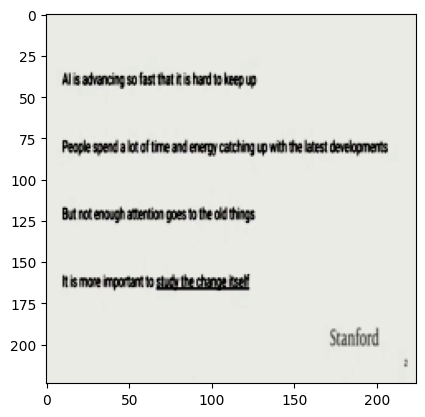

In [69]:
idx = np.random.randint(0, train_size)
img, lbl = train_dataset[idx]
print(f"样本[{idx}]: {img.shape}, 标签: {lbl}")  # 输出: 样本: torch.Size([3, 224, 224]), 标签: 1 (正例)

plt.imshow(img.permute(1, 2, 0));

In [80]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 112x112
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 56x56
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 28x28
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512), nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyModel().to(DEVICE)
print('parameters', sum(p.numel() for p in model.parameters()))

parameters 51475010


In [83]:
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

running_loss, running_dev_loss = [], []
running_acc, running_dev_acc = [], []

def train(epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0  # 记录训练分类准确率
        tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    
        for images, labels in tqdm_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
    
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
            # 计算分类准确率
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            running_loss.append(loss.item())
            running_acc.append(correct / total)
    
            tqdm_bar.set_postfix(loss=loss.item(), acc=f"{correct/total:.4f}")
    
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {total_loss/len(train_loader):.4f}, Train Acc: {correct/total:.4f}")
        if correct/total > .9:
            model_filename = f"slide_classifier_{epoch+1:03d}_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
            torch.save(model.state_dict(), model_filename)
            print("✅ 保存模型", model_filename)

        fig = plt.figure()
        plt.plot(running_loss, label='tr loss')
        plt.legend()
        fig = plt.figure()
        plt.plot(running_acc, label='tr acc')
        plt.legend()
        plt.show()

        # ✅ 验证阶段
        model.eval()
        dev_loss, dev_correct, dev_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in dev_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
    
                outputs = model(images)
                loss = criterion(outputs, labels)
                dev_loss += loss.item()
    
                preds = torch.argmax(outputs, dim=1)
                dev_correct += (preds == labels).sum().item()
                dev_total += labels.size(0)
    
        dev_acc = dev_correct / dev_total
        print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {dev_loss/dev_total:.4f}, Validation Accuracy: {dev_acc:.4f}")

Epoch 1/5: 100%|████████████████████████████████████| 18/18 [01:18<00:00,  4.35s/it, acc=0.8561, loss=0.00547]


Epoch [1/3], Train Loss: 0.3768, Train Acc: 0.8561
✅ 保存模型 slide_classifier_001_20250210_110642.pth


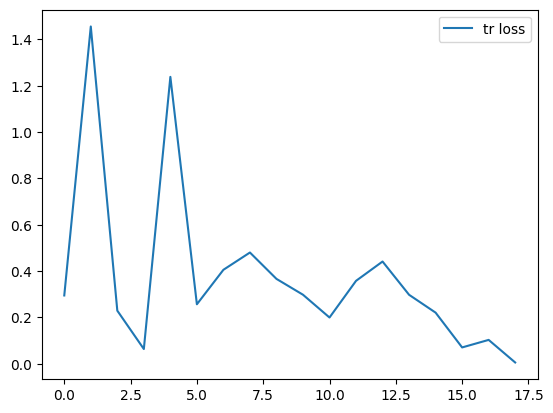

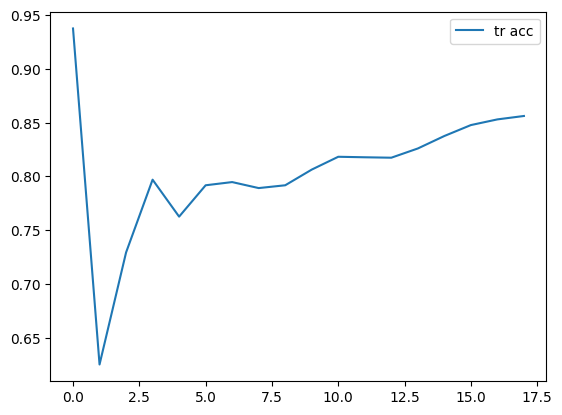

Validation Loss: 0.0319, Validation Accuracy: 0.9000


Epoch 2/5: 100%|██████████████████████████████████████| 18/18 [01:20<00:00,  4.50s/it, acc=0.9209, loss=0.284]


Epoch [2/3], Train Loss: 0.2328, Train Acc: 0.9209
✅ 保存模型 slide_classifier_002_20250210_110826.pth


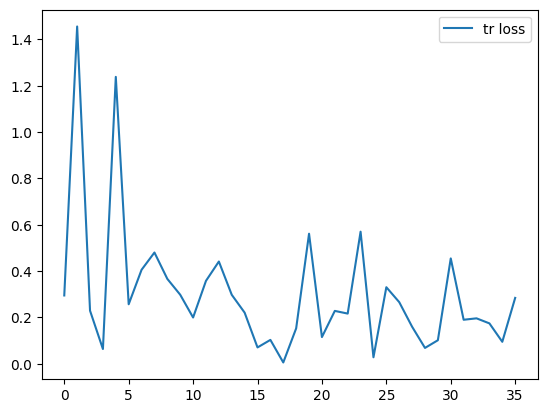

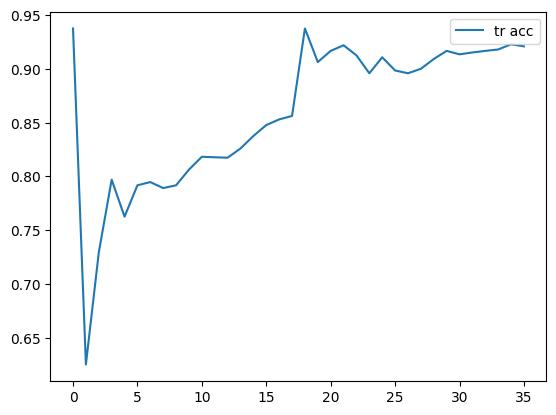

Validation Loss: 0.0127, Validation Accuracy: 0.9083


Epoch 3/5: 100%|██████████████████████████████████████| 18/18 [01:19<00:00,  4.43s/it, acc=0.9460, loss=0.288]


Epoch [3/3], Train Loss: 0.1355, Train Acc: 0.9460
✅ 保存模型 slide_classifier_003_20250210_111011.pth


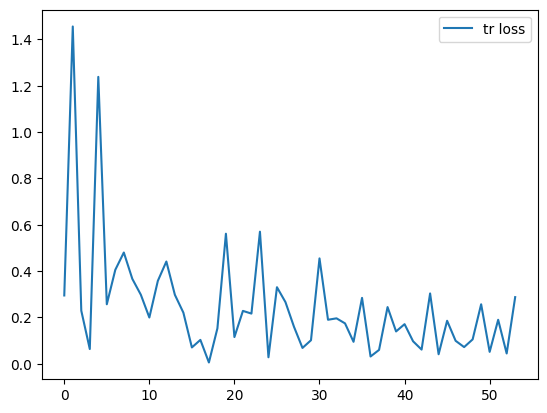

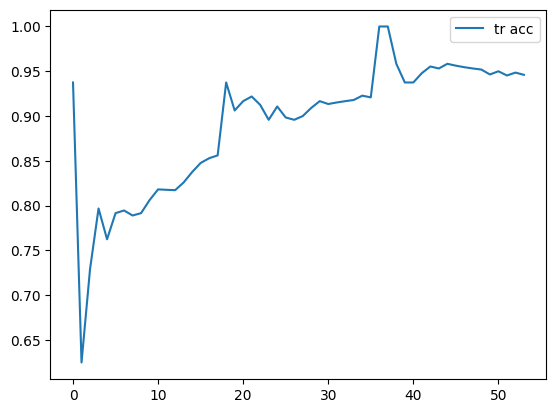

Validation Loss: 0.0111, Validation Accuracy: 0.9167


Epoch 4/5: 100%|██████████████████████████████████████| 18/18 [01:17<00:00,  4.29s/it, acc=0.9748, loss=0.316]


Epoch [4/3], Train Loss: 0.0944, Train Acc: 0.9748
✅ 保存模型 slide_classifier_004_20250210_111151.pth


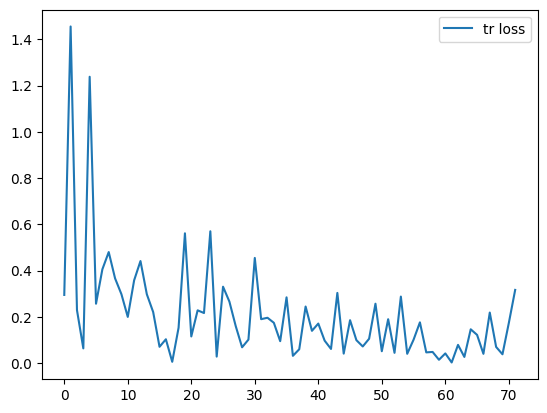

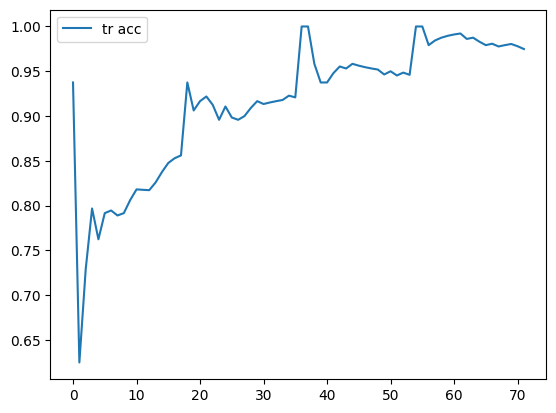

Validation Loss: 0.0132, Validation Accuracy: 0.9583


Epoch 5/5: 100%|██████████████████████████████████████| 18/18 [01:18<00:00,  4.36s/it, acc=0.9568, loss=0.141]


Epoch [5/3], Train Loss: 0.1192, Train Acc: 0.9568
✅ 保存模型 slide_classifier_005_20250210_111333.pth


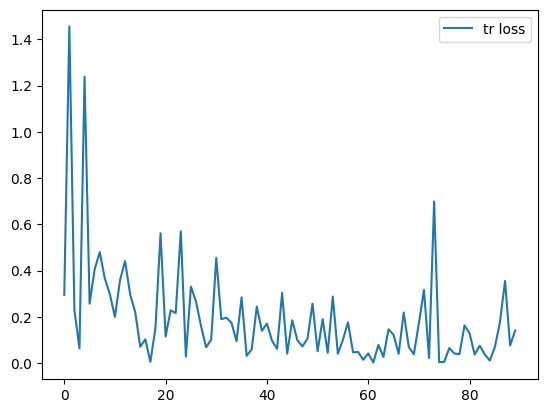

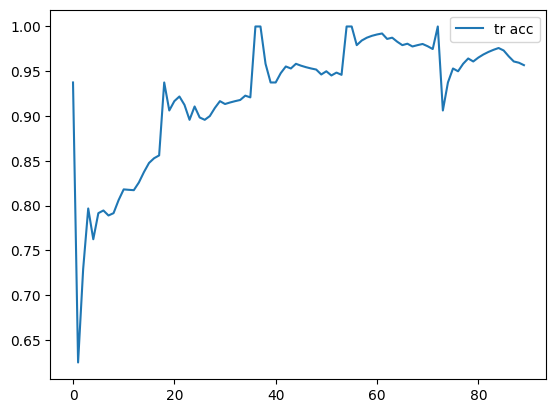

Validation Loss: 0.0082, Validation Accuracy: 0.9333


In [84]:
train(5)

In [73]:
model_filename = f"slide_classifier_{epoch+1:03d}_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
torch.save(model.state_dict(), model_filename)
print("✅ 保存模型", model_filename)

✅ 保存模型 slide_classifier_001_20250210_104540.pth


In [ ]:
def load_checkpoint(filename, model, optimizer=None):
    """加载 Checkpoint"""
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    
    print(f"✅ Checkpoint loaded: {filename}, Resuming from Epoch {start_epoch}")
    return start_epoch, loss

Example usage:
start_epoch, loss = load_checkpoint("xxx", model, optimizer)

In [62]:
torch.save(model.state_dict(), "slide_classifier.pth")

In [53]:
def load_labeled_images():
    """ 读取正例和负例文件，返回两个列表 """
    positive_images, negative_images = set(), set()
    
    if os.path.exists(POSITIVE_LABEL_FILE):
        with open(POSITIVE_LABEL_FILE, "r") as f:
            positive_images = set(line.strip() for line in f)
    
    if os.path.exists(NEGATIVE_LABEL_FILE):
        with open(NEGATIVE_LABEL_FILE, "r") as f:
            negative_images = set(line.strip() for line in f)

    return list(positive_images), list(negative_images)


def get_all_images(base_dir):
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")
    images = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(image_extensions):
                rel_path = os.path.relpath(os.path.join(root, file), base_dir)
                images.append(rel_path)
    return sorted(images)

all_images = get_all_images(IMAGE_BASE_PATH)
positive_images, negative_images = load_labeled_images()
labeled_images = set(positive_images + negative_images)
filtered_images = [img for img in all_images if img not in labeled_images]
len(all_images), len(labeled_images), len(filtered_images)

(403, 385, 18)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1 预测结果: 正例
1 预测结果: 正例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47450978..0.94509804].


1 预测结果: 正例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4980392..0.92941177].


0 预测结果: 负例
0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.52156866].


0 预测结果: 负例
0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46666664..0.9607843].


1 预测结果: 正例
1 预测结果: 正例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4980392..0.9843137].


1 预测结果: 正例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29411763..0.9529412].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


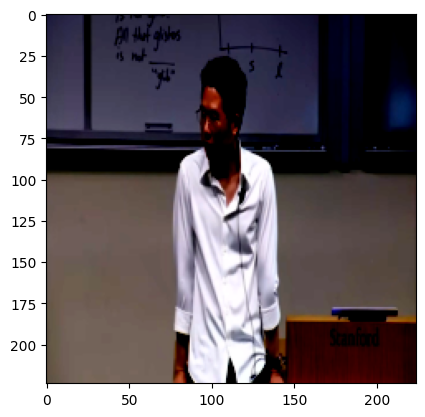

In [61]:
def predict_image(image_path, model, transform, device):
    """ 加载图片，进行预处理，并分类 """
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # 增加 batch 维度

    with torch.no_grad():
        output = model(image)  # 获取 logits
        predicted_class = torch.argmax(output, dim=1).item()  # 获取最大概率类别

    return image, predicted_class

# ✅ 预测新图片
samples = random.sample(filtered_images, BATCH_SIZE)
for img_path in samples:
    img_path = os.path.join(IMAGE_BASE_PATH, img_path)
    img, label = predict_image(img_path, model, transform, DEVICE)
    img = img.squeeze(0)
    plt.imshow(img.permute(1, 2, 0))
    print(label, f"预测结果: {'正例' if label == 1 else '负例'}")
    
#image_path = "test_image.jpg"
#label = predict_image(image_path, model, transform, device)
#print(f"预测结果: {'正例' if label == 1 else '负例'}")